# Deep Neural Networks 
## Session 03c

##  [Yolo V3](https://pjreddie.com/darknet/yolo/)

In [1]:
### Import Libraries

import tensorflow as tf

import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

import cv2

import struct

from util.yolov3_util import decode_netout, WeightReader, correct_yolo_boxes, do_nms, make_yolov3_model

from tensorflow.keras.layers import Conv2D

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.models import Model

# physical_devices = tf.config.list_physical_devices('GPU') 

# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# %matplotlib inline

2023-01-04 14:34:26.209435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 14:34:26.372817: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-04 14:34:26.376501: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-04 14:34:26.376515: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# Some basic parameters

inpDir = '../input' # location where input data is stored

outDir = '../output' # location to store outputs

mdlDir = '../models' # location to store outputs

altName = 'yolov3'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

EPOCHS = 100 # number of cycles to run

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large'
         }

plt.rcParams.update(params) # update rcParams

## Overview
The most salient feature of v3 is that it makes detections at three different scales.
### [Bounding box](http://christopher5106.github.io/object/detectors/2017/08/10/bounding-box-object-detectors-understanding-yolo.html)
YOLO v3 predicts boxes at 3 different scales. For the same image of 416 x 416, the number of predicted boxes are 10,647.

### Positives and negatives, and the cells

A position on the grid, that is the closest position to the center of one of the ground truth bounding boxes, is positive. Other positions are negative. The cell in the figure below gathers all possible position for the center of a ground truth box to activate the network output as positive:

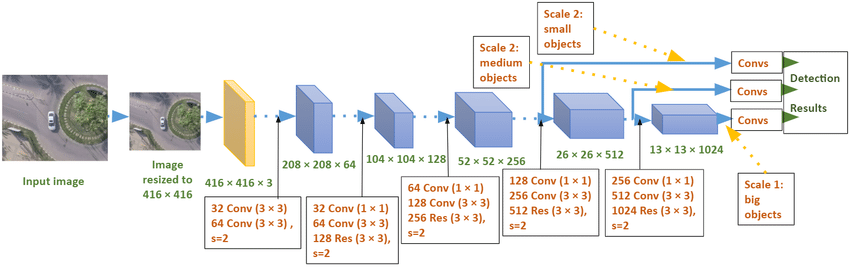

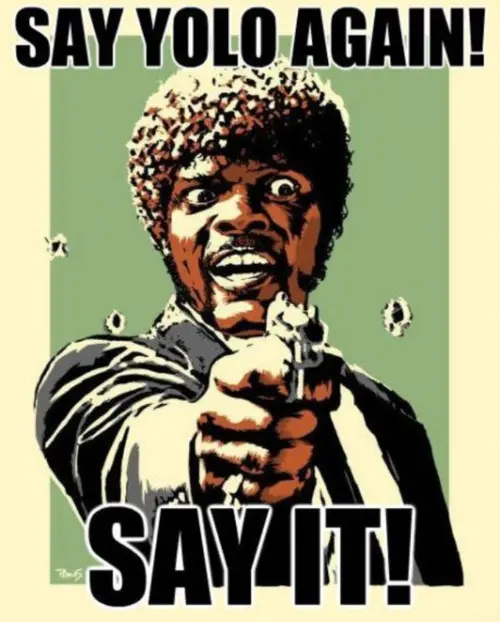

In [3]:
# define the labels
'''labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
'''
labels = ["person", "bicycle", "car", "motorbike", "pottedplant"]

# define the expected input shape for the model
input_w, input_h = 416, 416

# Anchor Size
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the probability threshold for detected objects
class_threshold = 0.1 # 0.5 #0.7 # 0.3

nonmaxsup_threshold= 0.2 #0.45 

### Note on Anchors

Anchors are determined by a k-means procedure, looking at all the bounding boxes in the dataset. 

Looking at vehicles, the ones we see from the side will have an aspect ratio of about 2:1 (width = 2 x height). Viewed from front, will be roughly square, 1:1. 

If dataset includes people, the aspect ratio might be 1:3. 

Foreground objects will be large, background objects will be small. 

The k-means routine will figure out a selection of anchors that represent your dataset. k=5 for yolov3, but there are different numbers of anchors for each YOLO version.



In [17]:
test_data_dir = os.path.join(inpDir, altName)
    
imgList = [f for f in os.listdir(test_data_dir) if os.path.isfile(os.path.join(test_data_dir, f))]

In [18]:
imgList

['yolo_positives.png',
 'yolo_v3.xcf',
 'IMG_1296.JPG',
 'autorikshaw.jpeg',
 'IMG_1292.JPG',
 'IMG_1295.JPG',
 'conv_for_obj_dect.png',
 'IMG_1293_mod.png',
 'yolo_v3.png']

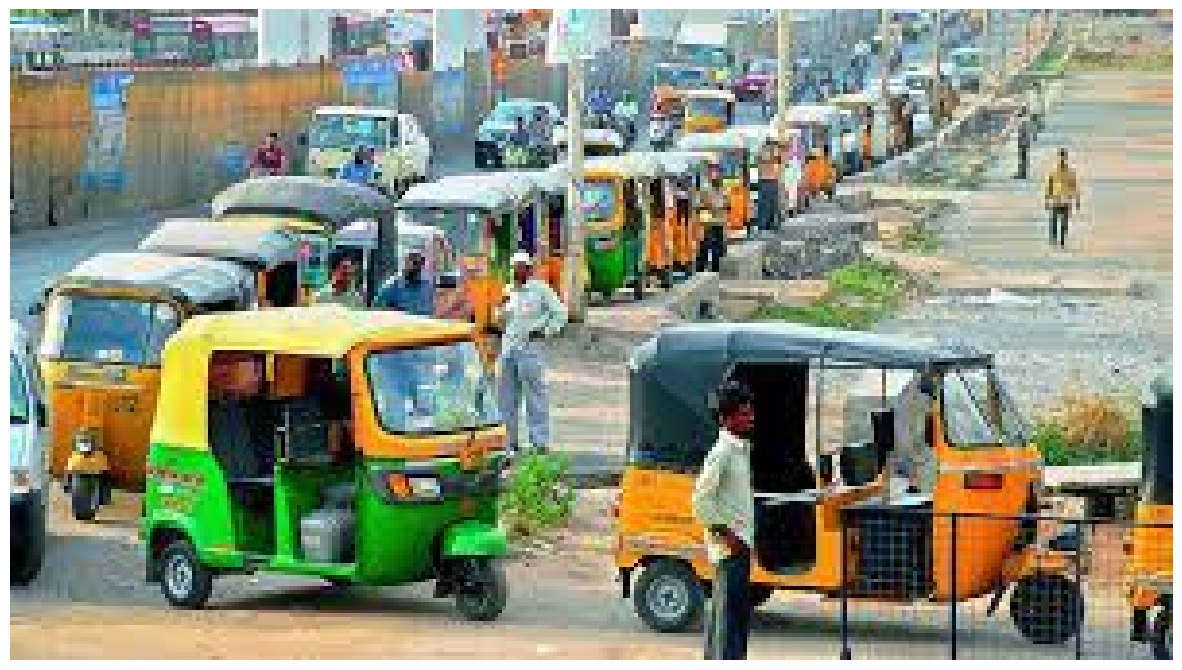

In [27]:
# define our new photo
imgPath = os.path.join(test_data_dir, imgList[3])

im = cv2.imread(imgPath, cv2.IMREAD_COLOR)

rgbIm = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

plt.imshow(rgbIm) # Plot the Image
    
plt.axis('off'); # no axis to display

In [7]:
model = make_yolov3_model() # define the model

weight_reader = WeightReader(os.path.join(mdlDir, altName, 'yolov3.weights')) # load the model weights

weight_reader.load_weights(model) # set the model weights into the model


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) # Compile the model

# save the model to file
model.save(os.path.join(mdlDir, altName, 'yolov3_model.h5'))

2023-01-04 14:34:30.712054: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dai/directory_env/environment1/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-04 14:34:30.712076: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-04 14:34:30.712109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dai-Precision-7820-Tower): /proc/driver/nvidia/version does not exist
2023-01-04 14:34:30.712333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operat

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv_0 (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, None, None,   128         ['conv_0[0][0]']                 
                                32)                                                           

                                                                                                  
 bnorm_9 (BatchNormalization)   (None, None, None,   256         ['conv_9[0][0]']                 
                                64)                                                               
                                                                                                  
 leaky_9 (LeakyReLU)            (None, None, None,   0           ['bnorm_9[0][0]']                
                                64)                                                               
                                                                                                  
 conv_10 (Conv2D)               (None, None, None,   73728       ['leaky_9[0][0]']                
                                128)                                                              
                                                                                                  
 bnorm_10 

                                256)                                                              
                                                                                                  
 bnorm_20 (BatchNormalization)  (None, None, None,   1024        ['conv_20[0][0]']                
                                256)                                                              
                                                                                                  
 leaky_20 (LeakyReLU)           (None, None, None,   0           ['bnorm_20[0][0]']               
                                256)                                                              
                                                                                                  
 add_5 (Add)                    (None, None, None,   0           ['add_4[0][0]',                  
                                256)                              'leaky_20[0][0]']               
          

 conv_32 (Conv2D)               (None, None, None,   294912      ['leaky_31[0][0]']               
                                256)                                                              
                                                                                                  
 bnorm_32 (BatchNormalization)  (None, None, None,   1024        ['conv_32[0][0]']                
                                256)                                                              
                                                                                                  
 leaky_32 (LeakyReLU)           (None, None, None,   0           ['bnorm_32[0][0]']               
                                256)                                                              
                                                                                                  
 add_9 (Add)                    (None, None, None,   0           ['add_8[0][0]',                  
          

                                                                                                  
 add_12 (Add)                   (None, None, None,   0           ['add_11[0][0]',                 
                                512)                              'leaky_42[0][0]']               
                                                                                                  
 conv_44 (Conv2D)               (None, None, None,   131072      ['add_12[0][0]']                 
                                256)                                                              
                                                                                                  
 bnorm_44 (BatchNormalization)  (None, None, None,   1024        ['conv_44[0][0]']                
                                256)                                                              
                                                                                                  
 leaky_44 

                                512)                                                              
                                                                                                  
 add_16 (Add)                   (None, None, None,   0           ['add_15[0][0]',                 
                                512)                              'leaky_54[0][0]']               
                                                                                                  
 conv_56 (Conv2D)               (None, None, None,   131072      ['add_16[0][0]']                 
                                256)                                                              
                                                                                                  
 bnorm_56 (BatchNormalization)  (None, None, None,   1024        ['conv_56[0][0]']                
                                256)                                                              
          

 bnorm_66 (BatchNormalization)  (None, None, None,   2048        ['conv_66[0][0]']                
                                512)                                                              
                                                                                                  
 leaky_66 (LeakyReLU)           (None, None, None,   0           ['bnorm_66[0][0]']               
                                512)                                                              
                                                                                                  
 conv_67 (Conv2D)               (None, None, None,   4718592     ['leaky_66[0][0]']               
                                1024)                                                             
                                                                                                  
 bnorm_67 (BatchNormalization)  (None, None, None,   4096        ['conv_67[0][0]']                
          

                                                                                                  
 leaky_77 (LeakyReLU)           (None, None, None,   0           ['bnorm_77[0][0]']               
                                512)                                                              
                                                                                                  
 conv_78 (Conv2D)               (None, None, None,   4718592     ['leaky_77[0][0]']               
                                1024)                                                             
                                                                                                  
 bnorm_78 (BatchNormalization)  (None, None, None,   4096        ['conv_78[0][0]']                
                                1024)                                                             
                                                                                                  
 leaky_78 

                                128)                                                              
                                                                                                  
 bnorm_96 (BatchNormalization)  (None, None, None,   512         ['conv_96[0][0]']                
                                128)                                                              
                                                                                                  
 leaky_96 (LeakyReLU)           (None, None, None,   0           ['bnorm_96[0][0]']               
                                128)                                                              
                                                                                                  
 up_sampling2d_1 (UpSampling2D)  (None, None, None,   0          ['leaky_96[0][0]']               
                                128)                                                              
          

 leaky_104 (LeakyReLU)          (None, None, None,   0           ['bnorm_104[0][0]']              
                                256)                                                              
                                                                                                  
 conv_81 (Conv2D)               (None, None, None,   261375      ['leaky_80[0][0]']               
                                255)                                                              
                                                                                                  
 conv_93 (Conv2D)               (None, None, None,   130815      ['leaky_92[0][0]']               
                                255)                                                              
                                                                                                  
 conv_105 (Conv2D)              (None, None, None,   65535       ['leaky_104[0][0]']              
          

# Plotting image of  the model

You need to install
>`sudo apt install graphviz` Refer [Graphviz](https://graphviz.gitlab.io/download/)

>`pip3 install pydot`

In [9]:
# !pip install pydot

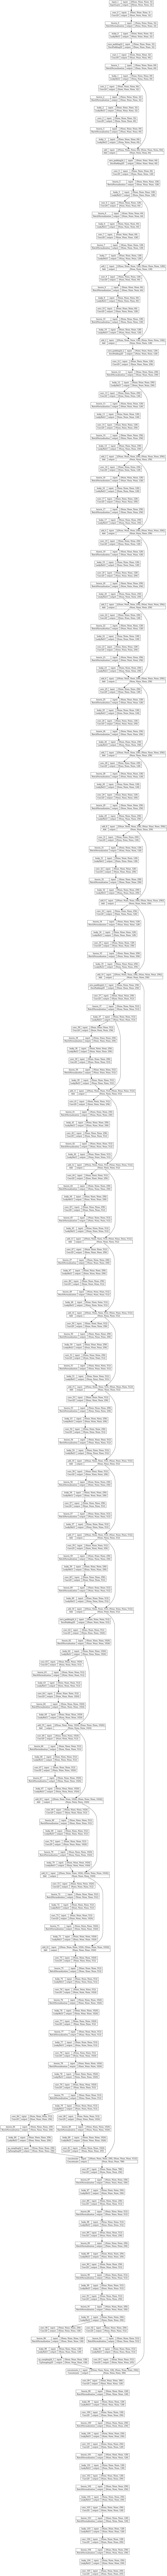

In [10]:
tf.keras.utils.plot_model(model, "yolo_v3.png", show_shapes=True)

In [11]:
# load yolov3 model
model = tf.keras.models.load_model(os.path.join(mdlDir, altName, 'yolov3_model.h5'))

In [12]:
# load and prepare an image
def load_image_pixels(filename, shape):
    
    # load the image to get its shape
    image = tf.keras.preprocessing.image.load_img(filename)
    width, height = image.size
    
    # load the image with the required size (Should not we be better off loading once????)
    image = tf.keras.preprocessing.image.load_img(filename, target_size=shape)
    
    # convert to a 3D Numpy array. 
    image = tf.keras.preprocessing.image.img_to_array(image)
    
    # scale values to between 0 and 1
    image = image.astype('float32')
    image /= 255.0
    
    #print ('before expand', image.shape, 'max pixel value', image.max())
    
    # add a dimension so that we have one sample
    image = tf.expand_dims(image, 0)
    #print ('after expand', image.shape)
    
    return image, width, height

In [13]:
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    
    # iterate all boxes
    for box in boxes:
        
        # iteratare all possible labels
        for i in range(len(labels)):
            
            # check if the threshold for this label is high enough to be listed
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100) # don't break, many labels may trigger for one box
                
    return v_boxes, v_labels, v_scores

In [14]:
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    
    # load the image
    data = plt.imread(filename)
    
    # plot the image
    plt.imshow(data)
    
    # get the context for drawing boxes
    ax = plt.gca()

    # plot each box
    for i in range(len(v_boxes)):
        
        box = v_boxes[i]
        
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        
        # draw the box
        ax.add_patch(rect)
        
        # draw text and score in top left corner
        label = "{:s} ({:.0f}%)".format(v_labels[i], v_scores[i])
        
        plt.text(x1, y1, label, color='white')
        
        img_name = filename.split('/')[-1]      
        
        plt.savefig(os.path.join(outDir, img_name))
    
    # show the plot
    plt.show()

In [28]:
# load and prepare image
image, image_w, image_h = load_image_pixels(imgPath, (input_w, input_h))

# make prediction
y_pred = model.predict(image)

# summarize the shape of the list of arrays
print([a.shape for a in y_pred])

boxes = list()
for i in range(len(y_pred)):
    # decode the output of the network
    boxes += decode_netout(y_pred[i][0], anchors[i], class_threshold, nonmaxsup_threshold, input_h, input_w)

# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

# suppress non-maximal boxes
do_nms(boxes, nonmaxsup_threshold)

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

# What did you find in the picture
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

1/1 [==============================] - 0s 427ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
car 70.8321213722229
car 36.54532730579376
person 83.1211268901825
person 91.21574759483337
person 31.580519676208496
car 33.18450748920441
person 62.44038939476013
person 83.55478048324585
person 33.437541127204895
person 50.51699876785278
person 19.799551367759705
person 57.16121196746826
person 87.05118298530579


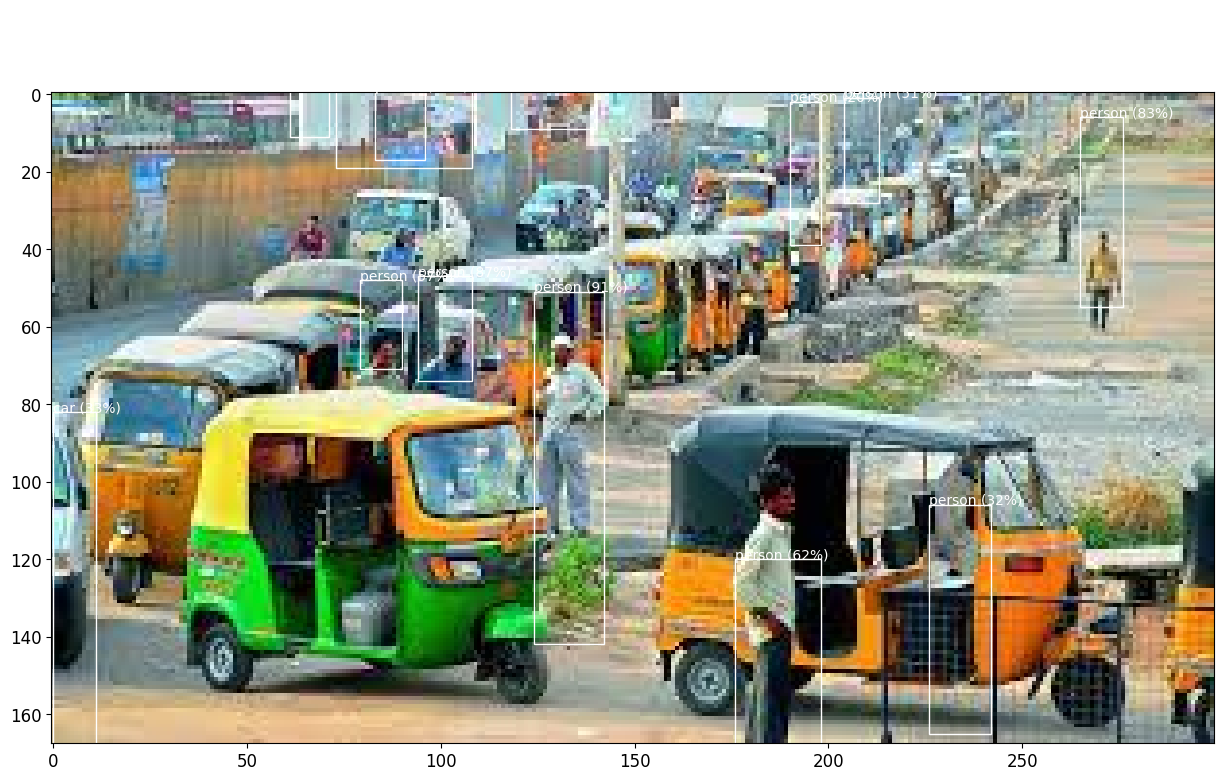

In [29]:
draw_boxes(imgPath, v_boxes, v_labels, v_scores)